In [1]:
import pickle
import json
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
timesformer_feats = pickle.load(open('./SportsFormer/data/ourds_videos_timesformer_features.pickle', 'rb'))
timesformer_feats['video1'].shape

(9, 768)

In [3]:
video_mae_feats = pickle.load(open('./finetuned_model_features_baseline_031023.pickle', 'rb'))
#video_mae_feats = pickle.load(open('./finetuned_model_features_baseline_using_image_transform.pickle', 'rb'))
video_mae_feats['video1'].shape

(5, 768)

In [4]:
finetuned_feats = pickle.load(open('./finetuned_model_features_trained_90masking_lr5e-5.pickle', 'rb'))
finetuned_feats['video1'].shape

(5, 768)

In [5]:
video = 'video2'

In [6]:
timesformer_feats[video][0][:20]

array([ 0.13970727,  1.1236087 ,  1.441256  , -0.22742607,  0.15748289,
       -1.5073246 , -0.7344954 , -1.0636863 ,  0.7772727 ,  0.46023658,
        0.13345502, -1.218375  ,  0.18118359,  0.13458802,  0.4837246 ,
       -1.929948  , -0.61254686, -0.14191802, -0.78059196,  1.259543  ],
      dtype=float32)

In [7]:
video_mae_feats[video][0][:20]

array([ 6.0034814 , -1.8576479 , -0.3536508 , -3.1393638 ,  3.7466552 ,
       -1.2207022 ,  0.19600898, -2.3155167 , -1.2764568 , -0.61917126,
        3.6292734 ,  0.15766269,  5.330416  , -0.7295516 ,  0.37535986,
       -2.4067223 ,  2.5470252 , -4.804395  , -0.2633228 ,  3.0376463 ],
      dtype=float32)

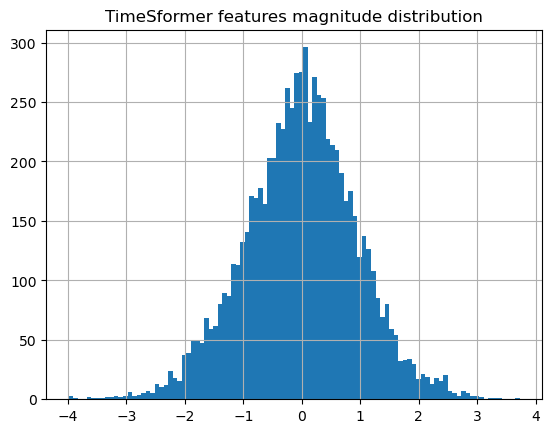

In [8]:
plt.hist(timesformer_feats[video].flatten(), bins=100)
plt.title("TimeSformer features magnitude distribution")
plt.grid()

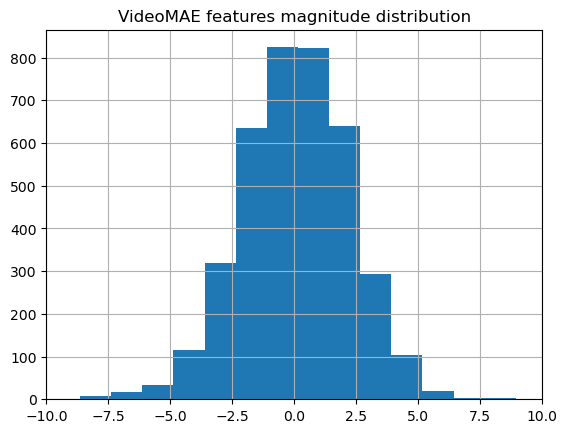

In [9]:
plt.hist(video_mae_feats[video].flatten(), bins=100)
plt.xlim(-10,10)
plt.title("VideoMAE features magnitude distribution")
plt.grid()

In [10]:
vm = video_mae_feats[video]
ts = timesformer_feats[video]
print(np.mean(ts), np.mean(vm), np.std(ts), np.std(vm))
print(np.max(timesformer_feats[video]), np.min(timesformer_feats[video]))
print(np.max(video_mae_feats[video]), np.min(video_mae_feats[video]))

-0.016965602 0.18544939 0.96050864 4.4206753
3.727171 -3.984377
116.86368 -8.642852


# Test if videos in the same game have similar representations

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [207]:
feats = timesformer_feats

In [208]:
gameid_to_videoid = json.load(open("./tools/gameid_eventid2vid.json"))
videoid_to_gameid = {}
for k in gameid_to_videoid.keys():
    videoid_to_gameid[gameid_to_videoid[k]] = k

In [209]:
video_keys = list(video_mae_feats.keys())
videoid_to_gameid[video_keys[0]]

'0021800083-349'

In [210]:
len(video_keys)

32018

In [211]:
max_video_len = 4
video_dim = 768
feats_np = np.zeros((len(video_keys),max_video_len,768))
feats_np.shape

(32018, 4, 768)

In [212]:
for i, vid in enumerate(tqdm.tqdm(video_keys)):
    vid_feats = feats[vid]
    if vid_feats.shape[0] > max_video_len:
        vid_feats = vid_feats[:max_video_len,:]
    feats_np[i,:vid_feats.shape[0],:] = vid_feats

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32018/32018 [00:00<00:00, 57363.84it/s]


In [213]:
flattened_feats_np = feats_np.reshape(32018, -1)

In [214]:
flattened_feats_np.shape

(32018, 3072)

In [215]:

def get_indices(game_num):
    """Gets all the indices from a specific GAME
    """
    game_id_list = np.array([videoid_to_gameid[x].split("-")[0] for x in video_keys])
    video_name = video_keys[game_num]
    game_id = videoid_to_gameid[video_name].split("-")[0]

    indices = []
    for i, g in enumerate(game_id_list):
        if g == game_id:
            indices.append(i)
    return indices

## Do PCA first

In [216]:
pca_out = PCA(n_components=5).fit_transform(flattened_feats_np)

In [217]:
pca_out.shape  # Each clip has a 10-dimensional representation

(32018, 5)

In [218]:
# First, we compare two games agains
colored = pca_out[get_indices(0)] #0
colored2 = pca_out[get_indices(10851)] #4

In [219]:
 videoid_to_gameid[video_keys[0]], videoid_to_gameid[video_keys[10851]]

('0021800083-349', '0021800094-652')

In [220]:
# Second, we compare two clips that are from the same game
aa,bb=0,21272
colored3 = pca_out[get_indices(aa)] #0
colored4 = pca_out[get_indices(bb)] #4
videoid_to_gameid[video_keys[aa]], videoid_to_gameid[video_keys[bb]]

('0021800083-349', '0021800182-101')

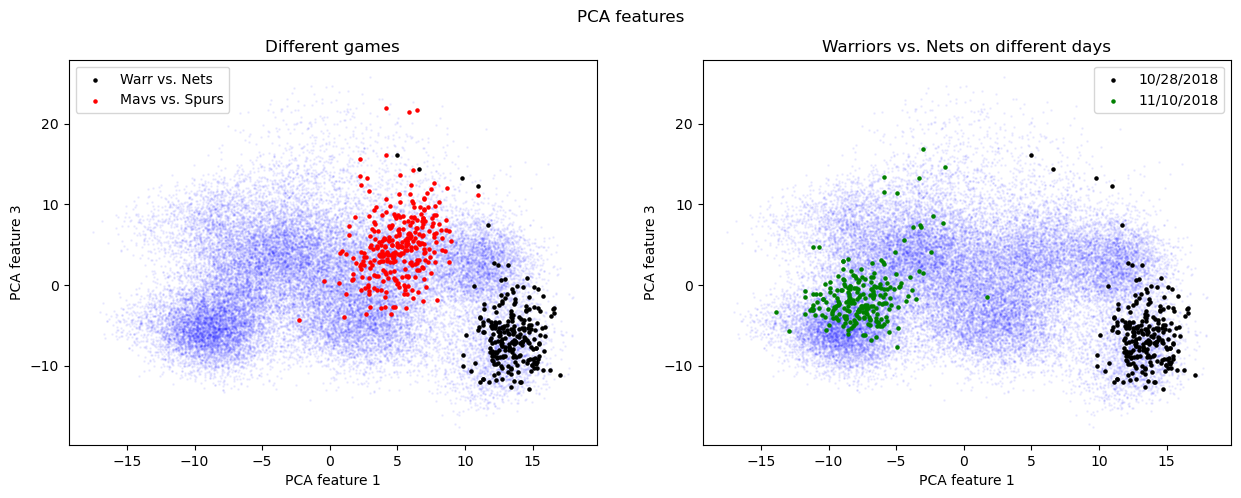

In [223]:
a, b = 0,2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('PCA features')

ax1.scatter(pca_out[:,a], pca_out[:,b],s=1,c="blue",alpha=0.05)
ax1.scatter(colored[:,a], colored[:,b],s=5,c="black", label="Warr vs. Nets")
ax1.scatter(colored2[:,a], colored2[:,b],s=5,c="red", label="Mavs vs. Spurs")
ax1.set_title("Different games")
ax1.set_xlabel("PCA feature " + str(a+1))
ax1. set_ylabel("PCA feature " + str(b+1))
ax1.legend()

ax2.scatter(pca_out[:,a], pca_out[:,b],s=1,c="blue",alpha=0.05)
ax2.set_title("Warriors vs. Nets on different days")
ax2.scatter(colored3[:,a], colored3[:,b],s=5,c="black", label="10/28/2018")
ax2.scatter(colored4[:,a], colored4[:,b],s=5,c="green", label="11/10/2018")
ax2.set_xlabel("PCA feature " + str(a+1))
ax2.set_ylabel("PCA feature " + str(b+1))
ax2.legend()

In [ ]:
# Idea: linear classification for the game using the features

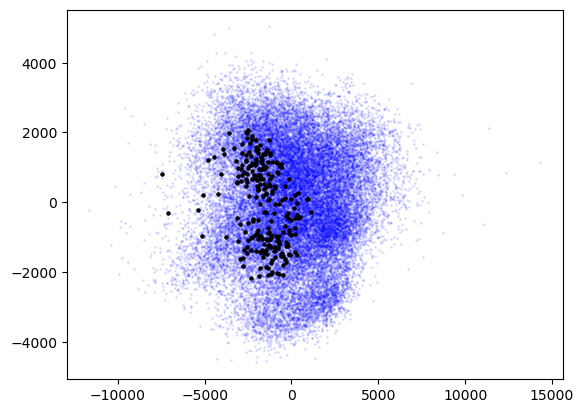

In [50]:

plt.scatter(pca_out[:,a], pca_out[:,b],s=1,c="blue",alpha=0.1)
plt.scatter(colored[:,a], colored[:,b],s=5,c="black")

(array([9.3000e+01, 2.0290e+03, 2.5411e+04, 3.5520e+03, 7.7100e+02,
        1.4000e+02, 1.5000e+01, 2.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([ 2. ,  3.1,  4.2,  5.3,  6.4,  7.5,  8.6,  9.7, 10.8, 11.9, 13. ]),
 <BarContainer object of 10 artists>)

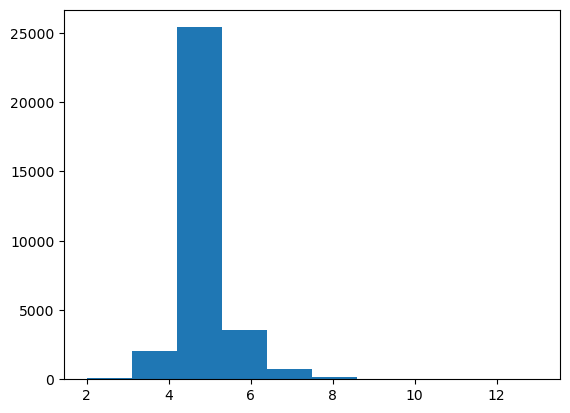

In [26]:
feats_lens = [feats[key].shape[0] for key in video_keys]
plt.hist(feats_lens)

In [27]:
blob_vids = np.array(video_keys)[pca_out[:,0] > 0]

(array([1.000e+00, 3.552e+03, 7.710e+02, 1.400e+02, 0.000e+00, 1.500e+01,
        2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 5. ,  5.8,  6.6,  7.4,  8.2,  9. ,  9.8, 10.6, 11.4, 12.2, 13. ]),
 <BarContainer object of 10 artists>)

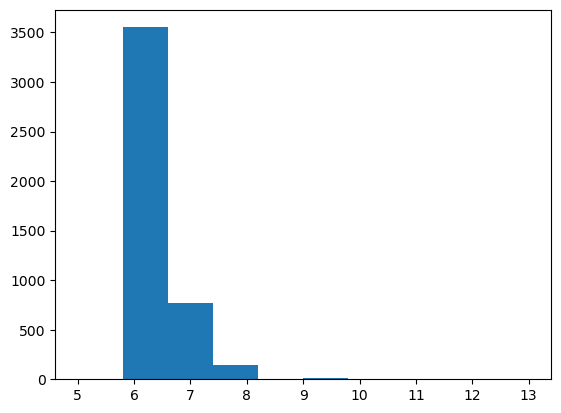

In [28]:
feats_lens = [feats[key].shape[0] for key in blob_vids]
plt.hist(feats_lens)

In [29]:
feats[blob_vids[1]].shape

(6, 768)

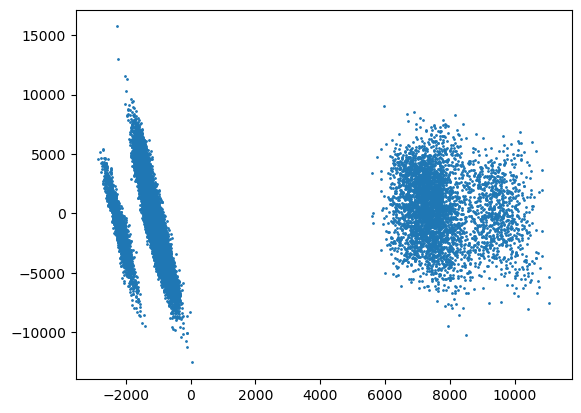

In [30]:
plt.scatter(pca_out[:,0], pca_out[:, 1],s=1)

## Then do TSNE

In [31]:
#X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',
#                  perplexity=5).fit_transform(X_pca)